# Idea & Plan

A few (mostly one) latent feature is always much more important for prediction than the rest (check `feature_importance`) 

- Are the CpGs connected to this latent feature also important? 
- Can we recover the CpGs important for prediction through perturbation? --> **PROOF OF CONCEPT THAT PERTURBATIONS WORK?!**

**Workflow**:

1. Predict with input CpGs: maximum R2?
2. Predict with all latent features: maximum R2 + important latent features? 
3. Predict only with important latent feature --> this is the maximum we can achieve!
4. Recover CpGs connected to this latent feature through perturbations (`low` + `medium` + `high` effect)
5. Predict AGE with those CpGs --> compare to other results!

In [5]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from scripts.visualisation import plot_cpg_reconstruction, plot_activations_latSpace

In [2]:
# def RFregression(X_train, y_train, X_test, y_test, saveModel=False, plot=True, color="orange", title=None):
#     ## Remove samples with NA in target
#     # Train
#     mask_train = ~np.isnan(y_train)
#     X_train = X_train[mask_train]
#     y_train = y_train[mask_train]
#     # Test
#     mask_test = ~np.isnan(y_test)
#     X_test = X_test[mask_test]
#     y_test = y_test[mask_test]

#     #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#     # Train RFregression model
#     regr = RandomForestRegressor(random_state=None)
#     regr.fit(X_train, y_train)
#     featureImportances = regr.feature_importances_

#     # Score on Test set
#     y_pred = regr.predict(X_test)
#     r2 = regr.score(X_test, y_test)

#     if saveModel:
#         # save model
#         outPath = f"logs/{name}/regression/"
#         os.makedirs(outPath, exist_ok=True)
#         pickle.dump(regr, open(f"{outPath}/RFregressor.sav", 'wb'))

#     if plot:
#         fig, (ax, ax2) = plt.subplots(1, 2,figsize=(15,5))
#         ax.scatter(y_test, y_pred, color=color)
#         ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red", linestyle="dashed", alpha=0.5)
#         ax.text(55, 10, f"R² = {round(r2.mean(),2)}")
#         ax.set_xlim(0,100)
#         ax.set_ylim(0,100)
#         if title: 
#             ax.set_title(f"{title}")
#         else: 
#             ax.set_title(f"{X_train.shape[1]} features")
#         ax.set_xlabel("True Age")
#         ax.set_ylabel("Predicted Age")

#         ax2.bar(x=range(len(featureImportances)), height=featureImportances, color=color)
#         ax2.set_title("Feature importance")
#         ax2.set_xlabel("# Feature")

#     return featureImportances, r2

# Load Data

In [3]:
PATH_data = "data"
PATH_results = "logs"

batch_size = 64
with open(os.path.join(PATH_data, "chr5_smoking_train.pkl"), "rb") as f: train_dataset = pickle.load(f) #
train_tensor = prepareDataLoader_fromPkl(f"{PATH_data}/chr5_smoking_train.pkl", colName="SMOKING").returnTensor_()

with open(os.path.join(PATH_data, "chr5_smoking_test.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

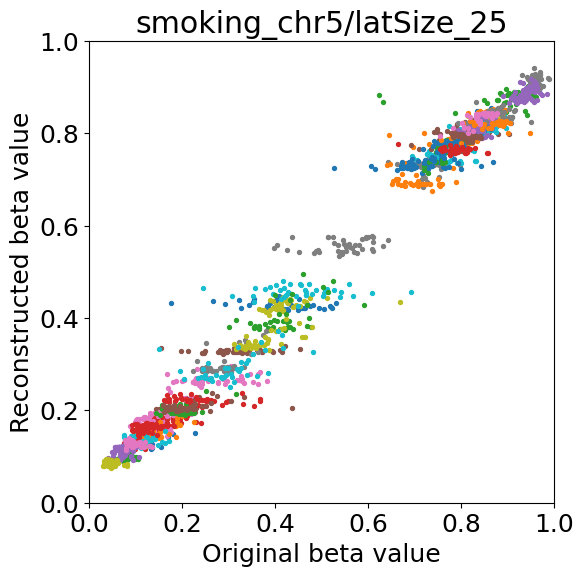

In [6]:
name2 = "smoking_chr5/latSize_25"
model2 = torch.load(f"logs/{name2}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

plot_cpg_reconstruction(model2, test_tensor, title=name2)

# Read in AE model (latent features = 25)

In [4]:
name = f"optLatSize/latSize_25" 
global name
model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

# From input CpGs 

## All input CpGs (4671 CpGs)

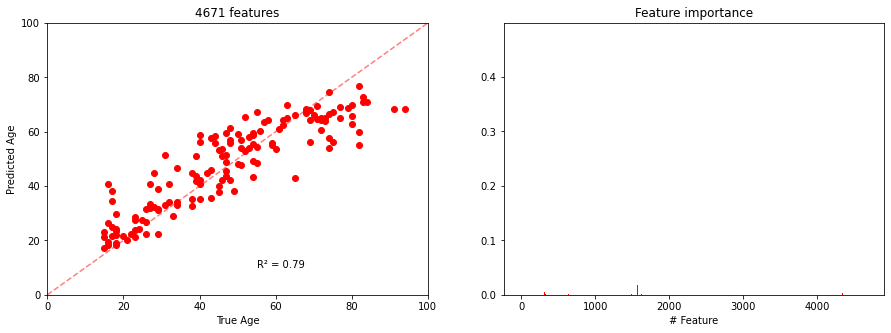

In [5]:
fi_all, _ = RFregression(X_train=train_tensor[0].detach().numpy(), 
                         y_train=train_tensor[1].detach().numpy(),
                         X_test=test_dataset["beta"].values,
                         y_test=test_dataset["pheno"]["Age"].values,
                         plot=True,
                         color="red")

## Top xx input Cpgs

- tried Recursive Feature Addition - too slow

Index(['cg18445088', 'cg01234420', 'cg01127300', 'cg07639287', 'cg27166177',
       'cg18448426', 'cg12325455', 'cg08415592', 'cg07127410', 'cg12373771'],
      dtype='object')


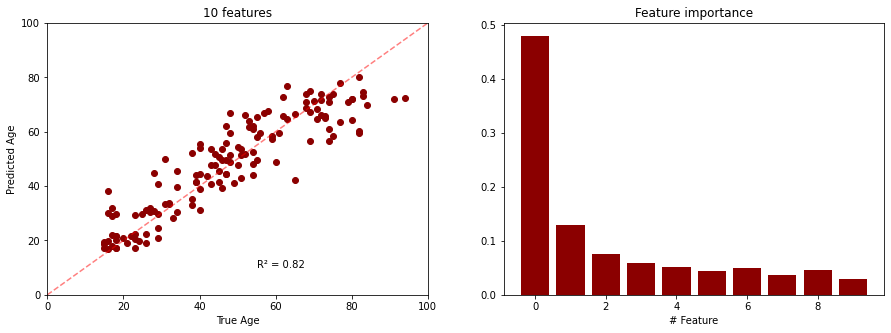

In [6]:
### Test: with xx best CpGs (from input)
i_best = 10
cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index

## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
y_train_latFeature = train_dataset["pheno"]["Age"].values
X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
_, r2 = RFregression(X_train=X_train_latFeature, 
                                y_train=y_train_latFeature,
                                X_test=X_test_latFeature,
                                y_test=y_test_latFeature,
                                plot=True,
                                color="darkred")

print(cpgs_best)

Text(0.5, 1.0, 'Optimal number of CpG features')

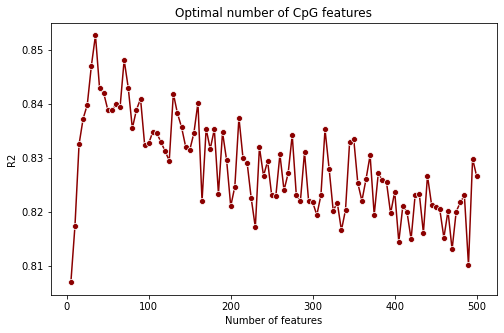

In [7]:
### check which number of top features is best

r2_tmp = []

tmp = list(range(5,501, 5)) #0
#tmp[0] += 1

for i_best in tmp: 
    ### Test: with xx best CpGs (from input)
    cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index

    ## parse only CpGs connected to latent feature 
    X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
    y_train_latFeature = train_dataset["pheno"]["Age"].values
    X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
    y_test_latFeature = test_dataset["pheno"]["Age"].values

    ## predict with those CpGs
    _, r2 = RFregression(X_train=X_train_latFeature, 
                                    y_train=y_train_latFeature,
                                    X_test=X_test_latFeature,
                                    y_test=y_test_latFeature,
                                    plot=False,
                                    color="darkred")

    r2_tmp.append(r2)


fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x=tmp, y=r2_tmp, color="darkred", marker="o")
ax.set_xlabel("Number of features")
ax.set_ylabel("R2")
ax.set_title("Optimal number of CpG features")

In [26]:
np.argmax(r2_tmp)
tmp[np.argmax(r2_tmp)]

35

Index(['cg18445088', 'cg01234420', 'cg01127300', 'cg07639287', 'cg27166177',
       'cg18448426', 'cg12325455', 'cg08415592', 'cg07127410', 'cg12373771',
       'cg06942979', 'cg15548613', 'cg26373518', 'cg20773033', 'cg00884093',
       'cg12379720', 'cg05329888', 'cg01514353', 'cg20571453', 'cg01949403',
       'cg08362785', 'cg10941566', 'cg15379633', 'cg20209308', 'cg02792538',
       'cg09146183', 'cg18613390', 'cg15383276', 'cg02713951', 'cg00058879',
       'cg07021644', 'cg14398464', 'cg20164887', 'cg02412616', 'cg09137533'],
      dtype='object')


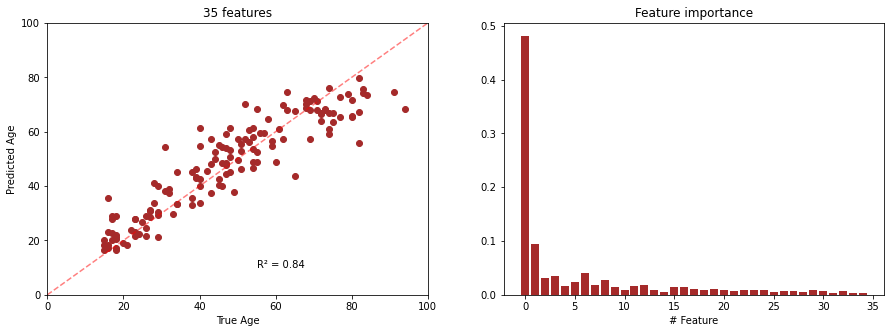

In [27]:
### Test: with xx best CpGs (from input)
i_best = tmp[np.argmax(r2_tmp)]
cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index

## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
y_train_latFeature = train_dataset["pheno"]["Age"].values
X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
_, r2 = RFregression(X_train=X_train_latFeature, 
                                y_train=y_train_latFeature,
                                X_test=X_test_latFeature,
                                y_test=y_test_latFeature,
                                plot=True,
                                color="brown")

print(cpgs_best)

## Everything except top xx CpGs (e.g. top 100)

(4571,)


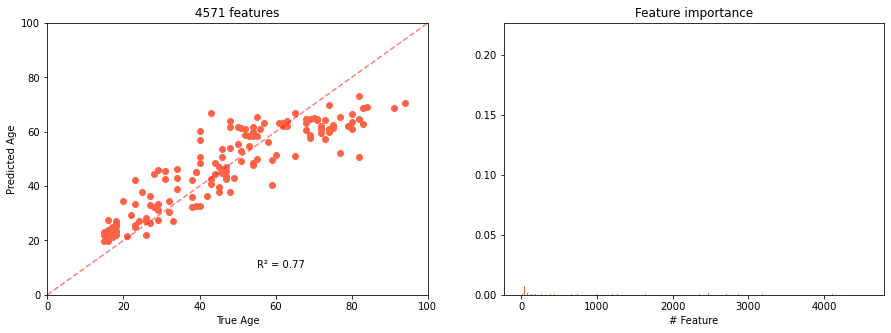

In [9]:
i_best = 100
### everything BUT best `i_best` features
cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[i_best:].index


## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
y_train_latFeature = train_dataset["pheno"]["Age"].values
X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
_, r2 = RFregression(X_train=X_train_latFeature, 
                                y_train=y_train_latFeature,
                                X_test=X_test_latFeature,
                                y_test=y_test_latFeature,
                                plot=True,
                                color="tomato")

print(cpgs_best.shape)

# From all latent space features

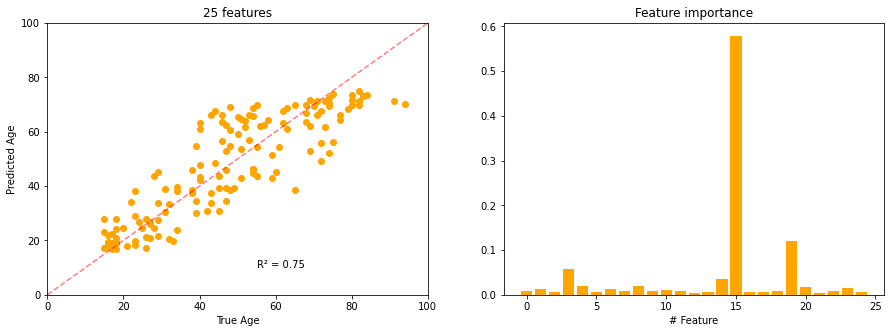

In [10]:
# Generate latent space
with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)  

fi, r2 = RFregression(X_train=latSpace_train, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="orange")

df_fi = pd.DataFrame(fi, index=range(latSpace_train.size(1)), columns=["fi"])
#df_fi

## Pre-experiment: permutation == deletion == perturbation?

Permuted feature: [14, 15, 16]
torch.Size([504, 25])
torch.Size([504, 25])
torch.Size([504, 22])


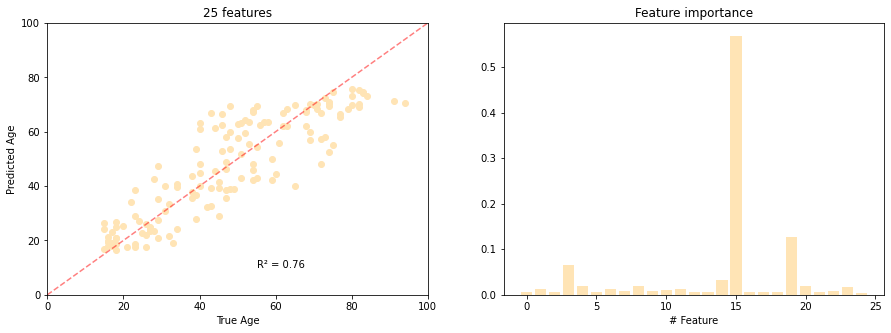

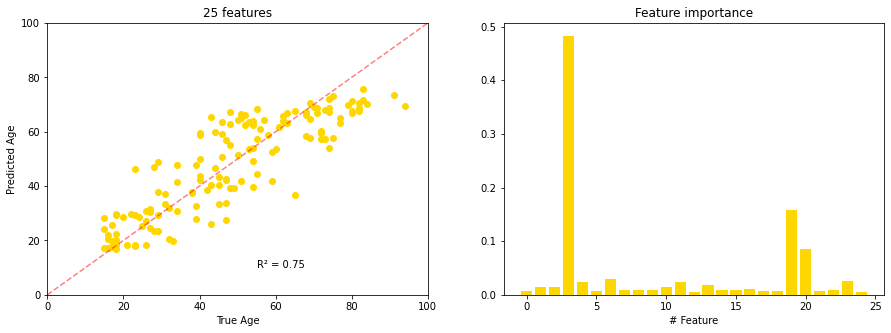

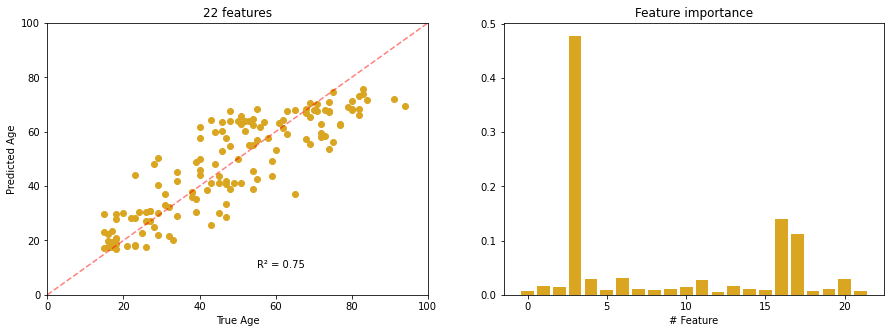

In [11]:
### Pre-experiment: permutation == deletion == perturbation?

latFeature_i = [14,15,16]
print(f"Permuted feature: {latFeature_i}")

### PERTURBATION
with torch.no_grad():
    latSpace_train_pert = model.generate_embedding(train_tensor[0])
    latSpace_train_pert[:,latFeature_i] = latSpace_train_pert[:,latFeature_i] + 10 #3*latSpace_train_pert[:,latFeature_i].std()
    #
    latSpace_test_pert = model.generate_embedding(test_tensor)  
    latSpace_test_pert[:,latFeature_i] = latSpace_test_pert[:,latFeature_i] + 10 #3*latSpace_test_pert[:,latFeature_i].std()

print(latSpace_train_pert.shape)
fi_perm, _ = RFregression(X_train=latSpace_train_pert, 
                          y_train=train_tensor[1].detach().numpy(),
                          X_test=latSpace_test_pert,
                          y_test=test_dataset["pheno"]["Age"].values,
                          plot=True,
                          color="moccasin")


### PERMUTATION
with torch.no_grad():
    latSpace_train_perm = model.generate_embedding(train_tensor[0])
    latSpace_train_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_train_perm[:,latFeature_i]))
    #
    latSpace_test_perm = model.generate_embedding(test_tensor)  
    latSpace_test_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_test_perm[:,latFeature_i]))

print(latSpace_train_perm.shape)
fi_perm, _ = RFregression(X_train=latSpace_train_perm, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test_perm,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="gold")

### DELETION
with torch.no_grad():
    latSpace_train_del = model.generate_embedding(train_tensor[0])
    latSpace_train_del = np.delete(latSpace_train_del, latFeature_i, axis=1)
    #
    latSpace_test_del = model.generate_embedding(test_tensor)  
    latSpace_test_del = np.delete(latSpace_test_del, latFeature_i, axis=1)

print(latSpace_train_del.shape)
fi_perm, _ = RFregression(X_train=latSpace_train_del, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test_del,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="goldenrod")


## RFE latent features 
Trying to solve mystery that all features are important?!

Permuted feature: [15]
Permuted feature: [15, 3]
Permuted feature: [15, 3, 20]
Permuted feature: [15, 3, 20, 19]
Permuted feature: [15, 3, 20, 19, 17]
Number of permuted features: 5 - [15, 3, 20, 19, 17]


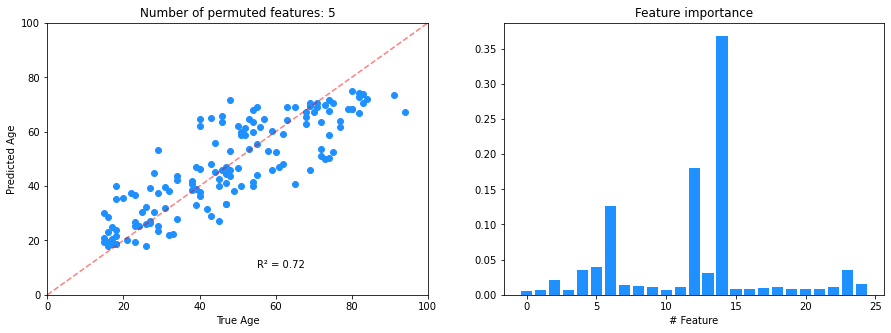

Permuted feature: [15, 3, 20, 19, 17, 14]
Permuted feature: [15, 3, 20, 19, 17, 14, 13]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23]
Number of permuted features: 10 - [15, 3, 20, 19, 17, 14, 13, 6, 12, 23]


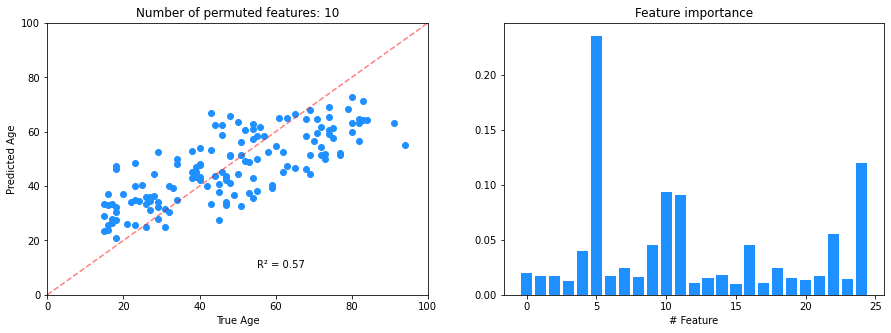

Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7]
Number of permuted features: 15 - [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7]


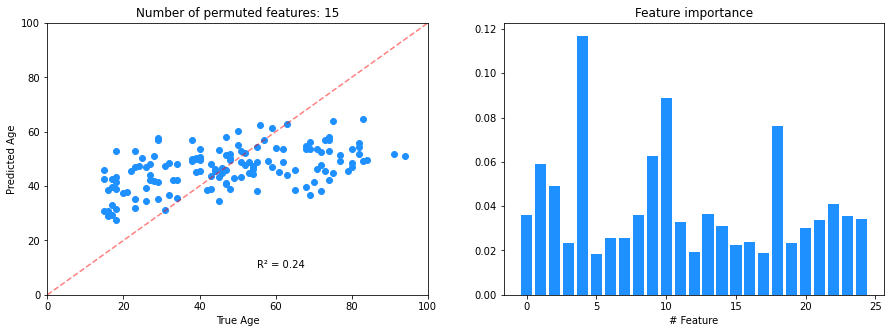

Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9, 22]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9, 22, 8]
Number of permuted features: 20 - [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9, 22, 8]


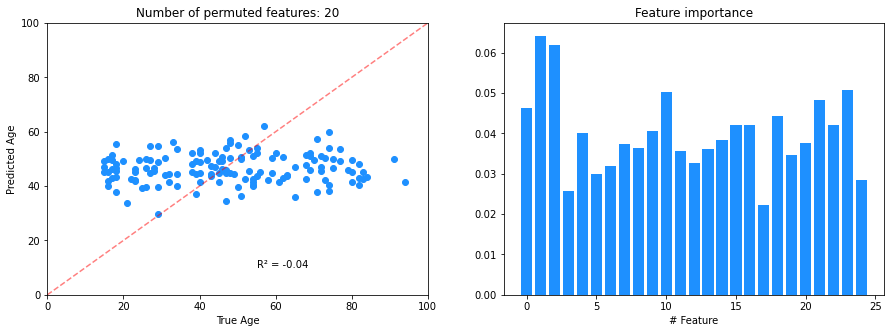

Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9, 22, 8, 1]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9, 22, 8, 1, 2]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9, 22, 8, 1, 2, 0]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9, 22, 8, 1, 2, 0, 10]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9, 22, 8, 1, 2, 0, 10, 21]
Number of permuted features: 25 - [15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9, 22, 8, 1, 2, 0, 10, 21]


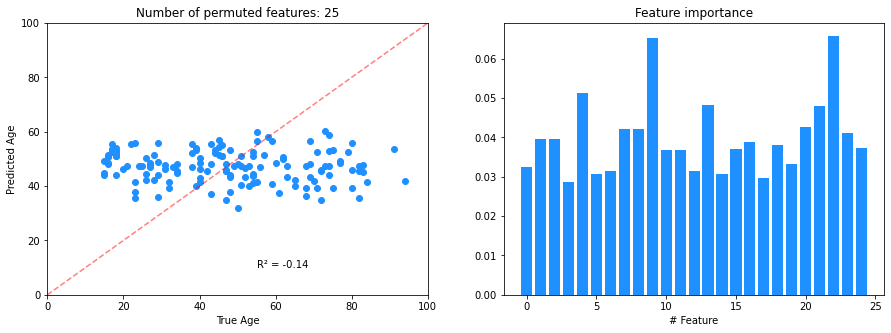

In [12]:
latFeature_i = [np.argmax(fi)]

dic_rfe = dict()
for i in range(25):
    print(f"Permuted feature: {latFeature_i}")
    ### PERMUTATION
    with torch.no_grad():
        latSpace_train_perm = model.generate_embedding(train_tensor[0])
        latSpace_train_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_train_perm[:,latFeature_i]))
        #
        latSpace_test_perm = model.generate_embedding(test_tensor)  
        latSpace_test_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_test_perm[:,latFeature_i]))

    ## plot every 5 features
    if len(latFeature_i) % 5 == 0:
        print(f"Number of permuted features: {len(latFeature_i)} - {latFeature_i}")
        fi_perm, r2_perm = RFregression(X_train=latSpace_train_perm, 
                            y_train=train_tensor[1].detach().numpy(),
                            X_test=latSpace_test_perm,
                            y_test=test_dataset["pheno"]["Age"].values,
                            plot=True,
                            color="dodgerblue", 
                            title=f"Number of permuted features: {len(latFeature_i)}")   ## make it even nicer by coloring the perturbed ones?!
        plt.show()
    else:
        fi_perm, r2_perm = RFregression(X_train=latSpace_train_perm, 
                            y_train=train_tensor[1].detach().numpy(),
                            X_test=latSpace_test_perm,
                            y_test=test_dataset["pheno"]["Age"].values,
                            plot=False)

    dic_rfe[str(latFeature_i)] = r2_perm
    latFeature_i.append(np.argmax(fi_perm))
    
    i += 1



Text(0.5, 1.0, 'Prediction accuracy upon latent feature permutation')

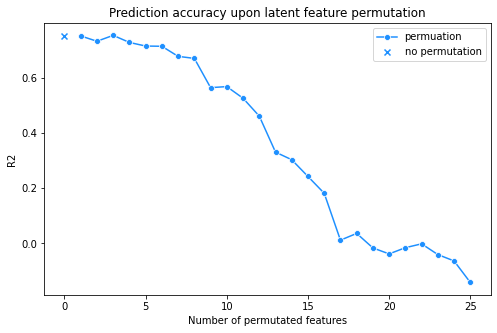

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(y=dic_rfe.values(), 
             x=[len(list(dic_rfe.keys())[i].split(",")) for i in range(len(dic_rfe.keys()))],
             marker="o",
             ax=ax,
             color="dodgerblue",
             label="permuation")
ax.scatter(x=0, y=r2, color="dodgerblue", label="no permutation", marker="x")
ax.legend()
ax.set_xlabel("Number of permutated features")
ax.set_ylabel("R2")
ax.set_title("Prediction accuracy upon latent feature permutation")

In [14]:
dic_rfe


{'[15]': 0.752611996669547,
 '[15, 3]': 0.7332951238505072,
 '[15, 3, 20]': 0.7546905558537577,
 '[15, 3, 20, 19]': 0.728975537135696,
 '[15, 3, 20, 19, 17]': 0.7159172577438755,
 '[15, 3, 20, 19, 17, 14]': 0.7150524576111152,
 '[15, 3, 20, 19, 17, 14, 13]': 0.6785109908956173,
 '[15, 3, 20, 19, 17, 14, 13, 6]': 0.6710764212965878,
 '[15, 3, 20, 19, 17, 14, 13, 6, 12]': 0.5650267944790016,
 '[15, 3, 20, 19, 17, 14, 13, 6, 12, 23]': 0.5688044196141939,
 '[15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5]': 0.5266035583659034,
 '[15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16]': 0.4617871985510812,
 '[15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24]': 0.3310945239798342,
 '[15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11]': 0.30352919813906676,
 '[15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7]': 0.24274782925419613,
 '[15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4]': 0.18185747821757825,
 '[15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18]': 0.01178611205658342,

# Predict with individual (best) latent features

Latent space feature with highest importance: 3


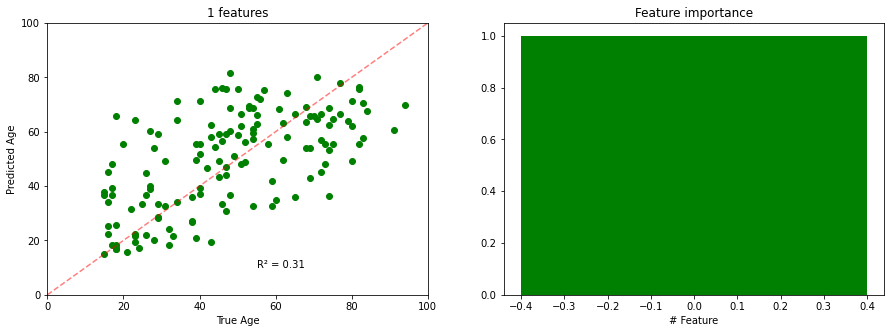

In [79]:
# Generate latent space

i = 3 #np.argmax(fi)

with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)  

print(f"Latent space feature with highest importance: {i}")
latSpace_train_highest = latSpace_train[:,i].reshape(-1, 1)
latSpace_test_highest = latSpace_test[:,i].reshape(-1, 1)    

_, _ = RFregression(X_train=latSpace_train_highest, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test_highest,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="green")

# CpG connections

## Connection of input CpGs with highest importance

- connected to many latent features? --> **YES**

In [16]:
PATH_allcpgs = "/home/sonja/PROJECTS/VAE_methylation/denseNetworkAnalysis/results/optLatSize/latSize_25/quantileCutoff_CpGfocus.csv"
connections_allcpgs = pd.read_csv(PATH_allcpgs, header=0, index_col=0)

In [31]:
connections_allcpgs

,cg19968835,cg14742445,cg21527637,cg17213870,cg15668074,cg25564144,cg08447200,cg01194538,cg17157725,cg21431832,...,cg16692439,cg16971128,cg00449189,cg07325001,cg20550677,cg10480239,cg26000393,cg07821417,cg00640609,cg00542638
latFeature_0,0,3,0,0,0,0,0,0,0,3,...,3,0,0,0,0,3,0,0,0,0
latFeature_1,0,3,0,0,0,0,0,0,0,2,...,3,0,0,0,0,2,0,0,0,0
latFeature_2,0,0,0,0,0,3,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
latFeature_3,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
latFeature_4,0,2,0,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
latFeature_5,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
latFeature_6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
latFeature_7,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
latFeature_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
latFeature_9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


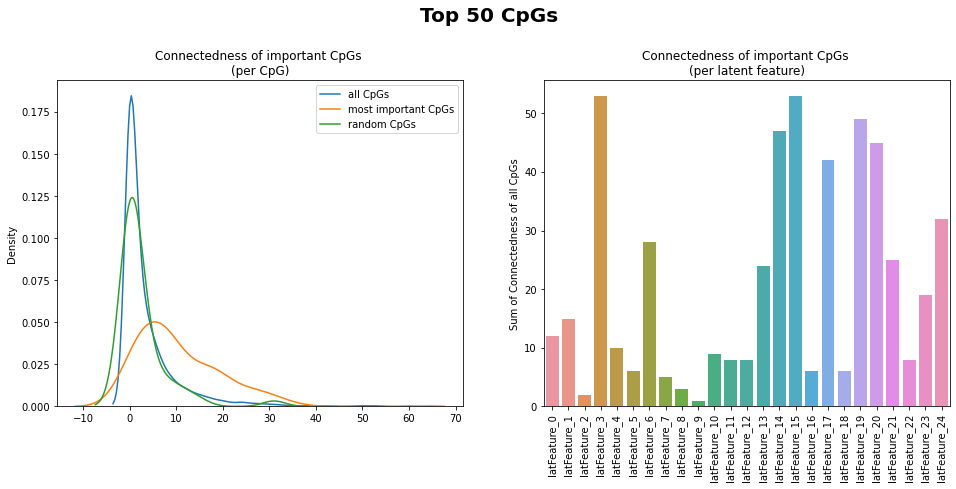

Order of latent feature permutations:
[15, 3, 20, 19, 17, 14, 13, 6, 12, 23, 5, 16, 24, 11, 7, 4, 18, 9, 22, 8, 1, 2, 0, 10, 21]


In [17]:
i_best = 50 #4671
best_cpgs = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index
#print(best_cpgs)

### DENSITY
fig, (ax, ax2) = plt.subplots(1,2,figsize=(16,6))
## all CpGs
sns.kdeplot(data=connections_allcpgs.sum(axis=0), label="all CpGs", ax=ax)
## best CpGs
sns.kdeplot(data=connections_allcpgs.loc[:,best_cpgs].sum(axis=0), label="most important CpGs", ax=ax)
## same number of randomly drawn CpGs
sns.kdeplot(data=connections_allcpgs.iloc[:,np.random.randint(len(connections_allcpgs.columns), size=i_best)].sum(axis=0), label="random CpGs", ax=ax)
ax.legend()
ax.set_title("Connectedness of important CpGs \n(per CpG)")

### PER LATENT FEATURE
sns.barplot(y=connections_allcpgs.loc[:,best_cpgs].sum(axis=1), 
            x=connections_allcpgs.index, 
            ax=ax2)
ax2.set_xticklabels(connections_allcpgs.index,rotation=90)
ax2.set_ylabel("Sum of Connectedness of all CpGs")
ax2.set_title("Connectedness of important CpGs \n(per latent feature)")
plt.suptitle(f"Top {i_best} CpGs", fontsize=20, fontweight ="bold", y=1.05)
plt.show()

print("Order of latent feature permutations:")
print(list(dic_rfe.keys())[-1])

## Retrieve CpG connections for all features

- retrieve CpGs (high effect of perturbation?) for each latent feature
- replicate old findings 

## For all features

In [18]:
### Test: with CpGs from another (unimportant) latent feature

all_r2 = []
all_fi = []
dic = dict()
for latFeature_i in range(25): #25

    print(f"Latent space feature: {latFeature_i}")
    PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/denseNetworkAnalysis/results/optLatSize/latSize_25/latFeature_{latFeature_i}"

    cpgs = pd.read_csv(f"{PATH_pert}/cpgs_high.txt", header=None) #cpgs_high_medium_low.txt
    print(f"Number of CpGs connected: {cpgs.shape[0]}")

    ## parse only CpGs connected to latent feature 
    X_train_latFeature = train_dataset["beta"].loc[:,cpgs[0]]
    y_train_latFeature = train_dataset["pheno"]["Age"].values

    X_test_latFeature = test_dataset["beta"].loc[:,cpgs[0]]
    y_test_latFeature = test_dataset["pheno"]["Age"].values

    ## predict with those CpGs
    fi_tmp, r2 = RFregression(X_train=X_train_latFeature, 
                                    y_train=y_train_latFeature,
                                    X_test=X_test_latFeature,
                                    y_test=y_test_latFeature,
                                    plot=False)
                                    #color="lightblue")
    print(r2)

    all_fi.append(fi_tmp)
    all_r2.append(r2)
    dic[latFeature_i] = cpgs[0].tolist()

print(all_r2)

Latent space feature: 0
Number of CpGs connected: 108
0.686856549158517
Latent space feature: 1
Number of CpGs connected: 110
0.6985901430492529
Latent space feature: 2
Number of CpGs connected: 82
0.6776646190408067
Latent space feature: 3
Number of CpGs connected: 68
0.7590878752052921
Latent space feature: 4
Number of CpGs connected: 78
0.6007493795514762
Latent space feature: 5
Number of CpGs connected: 49
0.6436376679389532
Latent space feature: 6
Number of CpGs connected: 49
0.5224986643624359
Latent space feature: 7
Number of CpGs connected: 55
0.6898588920578423
Latent space feature: 8
Number of CpGs connected: 22
0.2069571593867846
Latent space feature: 9
Number of CpGs connected: 22
0.1365675335076767
Latent space feature: 10
Number of CpGs connected: 98
0.6594529633707389
Latent space feature: 11
Number of CpGs connected: 38
0.4347650519310333
Latent space feature: 12
Number of CpGs connected: 58
0.680030420415334
Latent space feature: 13
Number of CpGs connected: 66
0.60384

Text(0.5, 1.0, 'Prediction with CpGs (high effect) for each latent feature')

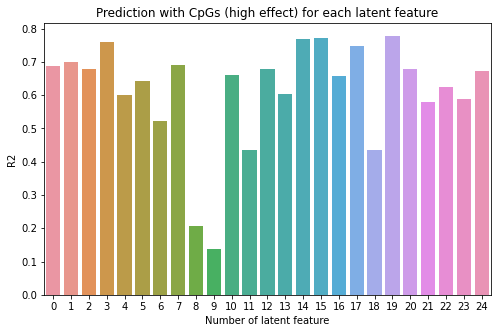

In [19]:
### TROUBLE PLOT

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=list(range(len(all_r2))), y=all_r2, ax=ax)
ax.set_xlabel('Number of latent feature')
ax.set_ylabel('R2')
ax.set_title('Prediction with CpGs (high effect) for each latent feature')
#ax.set_ylim(0.6, 0.8)

### Analyse in more detail why retrieved latent feature CpGs perform so similar

There should be a difference in mapped CpGs -- therefore also a difference in prediction performance...
--> we don't see this!

- we see that important CpGs have high connectivity and are mapped together in features (resulting in a high degree of connectedness for the features)
- if latent feature inspected alone: diluted and unclear picture -- perturbation deliver too broad results?!

In [20]:
# def runRFR(cpglist, title, c):
#     ## parse only CpGs connected to latent feature 
#     X_train_latFeature = train_dataset["beta"].loc[:,cpglist]
#     y_train_latFeature = train_dataset["pheno"]["Age"].values
#     X_test_latFeature = test_dataset["beta"].loc[:,cpglist]
#     y_test_latFeature = test_dataset["pheno"]["Age"].values

#     ## predict with those CpGs
#     fi, r2 = RFregression(X_train=X_train_latFeature, 
#                                     y_train=y_train_latFeature,
#                                     X_test=X_test_latFeature,
#                                     y_test=y_test_latFeature,
#                                     plot=True,
#                                     color=c,
#                                     title=title)
#     plt.show()

In [67]:
## load feature importances of all CpGs
df_fi = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)
df_fi['idx'] = range(df_fi.shape[0])

In [74]:
### CpGs overlapping between features

cpgs_0 = dic[0]   ### This feature is very very unimportant for prediction - should have worthless CpGs connected to it 
cpgs_15 = dic[15]   ### This feature is important for prediction - should have important CpGs connected to it 
cpgs_3 = dic[3]     ### Another important feature
cpgs_10 = dic[10]     ### Unimportant feature

## 1. CpGs overlapping between important and unimportant features             ## Overlapping CpGs are not important at all - they can not be the reason for the same performance
print([i for i in cpgs_15 if i in cpgs_0])
print(df_fi.loc[[i for i in cpgs_15 if i in cpgs_0],:])     

## 1B. CpGs overlapping between important features
print([i for i in cpgs_15 if i in cpgs_3])
print(df_fi.loc[[i for i in cpgs_15 if i in cpgs_3],:])   

## 1c. CpGs overlapping between unimportant features
print([i for i in cpgs_0 if i in cpgs_10])
print(df_fi.loc[[i for i in cpgs_0 if i in cpgs_10],:])   


['cg15242686', 'cg11141652', 'cg04234412', 'cg14112997', 'cg17005068', 'cg17662493', 'cg13318129']
                       0   idx
cg15242686  4.840067e-05   978
cg11141652  3.301249e-06  3132
cg04234412  9.051230e-07  3876
cg14112997  2.071498e-06  3444
cg17005068  2.640918e-05  1430
cg17662493  1.052405e-05  2218
cg13318129  1.525109e-06  3614
['cg07127410', 'cg00944631', 'cg02556928', 'cg03364108', 'cg01808030', 'cg10941566', 'cg01660911', 'cg10836392', 'cg04965050', 'cg12325455', 'cg01141459', 'cg07021644', 'cg25125450', 'cg11961401', 'cg17662493', 'cg07153010', 'cg13318129', 'cg14894848', 'cg02339083', 'cg20721738', 'cg11821795', 'cg12252109', 'cg01234420', 'cg26921612']
                       0   idx
cg07127410  1.561408e-02     8
cg00944631  1.505955e-05  1912
cg02556928  4.687068e-04    94
cg03364108  3.884197e-04   117
cg01808030  5.705379e-06  2712
cg10941566  3.228188e-03    21
cg01660911  1.591644e-04   310
cg10836392  7.327974e-05   682
cg04965050  6.393248e-08  4518
cg1232

In [73]:
len([i for i in cpgs_0 if i in cpgs_10])

46

In [71]:
len(cpgs_0)

108

In [72]:
len(cpgs_10)

98

## For a selected latent feature (e.g. 15)

Latent space feature with highest importance: 15
Number of CpGs connected: 70


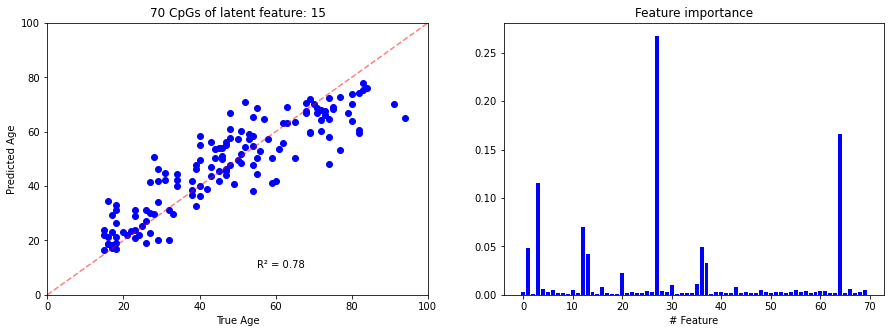

In [76]:
latFeature_i = 15

print(f"Latent space feature with highest importance: {latFeature_i}")
PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/denseNetworkAnalysis/results/optLatSize/latSize_25/latFeature_{latFeature_i}"

cpgs = pd.read_csv(f"{PATH_pert}/cpgs_high.txt", header=None) #cpgs_high_medium_low.txt
print(f"Number of CpGs connected: {cpgs.shape[0]}")

## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs[0]]
y_train_latFeature = train_dataset["pheno"]["Age"].values

X_test_latFeature = test_dataset["beta"].loc[:,cpgs[0]]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
fi_i, _ = RFregression(X_train=X_train_latFeature, 
                    y_train=y_train_latFeature,
                    X_test=X_test_latFeature,
                    y_test=y_test_latFeature,
                    plot=True,
                    color="blue",
                    title=f"{len(cpgs[0])} CpGs of latent feature: {latFeature_i}")

## For randomly selected CpGs (with same number of CpGs as latent features)

In [55]:
all_r2_random = []

for i_iter in range(100):
    ### Test: with xx random CpGs (same as best latent feature)
    i = len(fi_i)
    cpgs = np.random.choice(train_dataset["beta"].columns, i)


    ## parse only CpGs connected to latent feature 
    X_train_latFeature = train_dataset["beta"].loc[:,cpgs]
    y_train_latFeature = train_dataset["pheno"]["Age"].values

    X_test_latFeature = test_dataset["beta"].loc[:,cpgs]
    y_test_latFeature = test_dataset["pheno"]["Age"].values

    ## predict with those CpGs
    _, r2 = RFregression(X_train=X_train_latFeature, 
                                    y_train=y_train_latFeature,
                                    X_test=X_test_latFeature,
                                    y_test=y_test_latFeature,
                                    plot=False)
                                    # plot=True,
                                    # color="cyan")
    all_r2_random.append(r2)

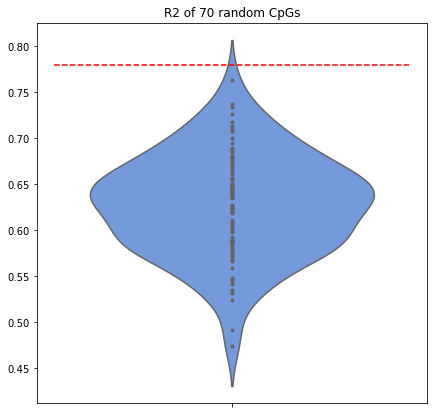

0.627964312275638 0.054410661547226215


In [56]:
fig, ax = plt.subplots(figsize=(7,7))

sns.violinplot(data=all_r2_random, color="cornflowerblue", inner="point") #"cornflowerblue"
ax.hlines(0.78, -0.5,0.5, color="red", linestyles='dashed')
ax.set_title(f"R2 of {len(fi_i)} random CpGs")
ax.set_xticklabels("")
plt.show()

print(np.array(all_r2_random).mean(), np.array(all_r2_random).std())